In [1]:
import pandas as pd
import numpy as np
import fastai
from fastai.vision import *
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import glob
import json
from skimage import io, transform

# Requirements

Data format:
* Faces and STFTs must have been extracted with the notebook Extract faces and sound.ipynb.
* In each video folder ('train_sample_videos', 'dfdc_train_videos_X', ...'), there must be a folder named 'face_frames' containing folders of faces and stfts for each video.

Libraries:
* pytorch
* fastai

In [2]:
PATH_ROOT_DIR = "/media/dlo/New Volume/DeepFake/"
AUDIO_EXTENSION = ".jpg"
LABEL_FILE = "metadata.json"
root_dirs = ["train_sample_videos/"]

# train on all set
#root_dirs = glob(f"{PATH_ROOT_DIR}/*/")

In [3]:
###################################################################
# Data preparation (indexing of extracted faces & stft per video) #
# Custom pytorch dataset creation                                 #
###################################################################

# Data preparation
class DeepFakeDF():
    """ Indexes the faces & STFTs into a dataframe, to be used
    by the pytorch dataset. processing is a bit long"""
    def __init__(self, data_dirs, test = False):
        self.data_dirs = [f"{PATH_ROOT_DIR}{d}" for d in data_dirs]
        self.frame_dirs = [f"{d}face_frames/" for d in self.data_dirs]
        
        audio = []
        video = []
        for frame_dir in self.frame_dirs:
            audio.extend(glob.glob(f"{frame_dir}*/audio*"))
            video.extend(glob.glob(f"{frame_dir}*/webcam*"))
            
        if not test:
            self.labels = self._get_labels()
        else:
            self.labels = {}
            
        self.video = video
        self.df = self._prep_df_audio(audio)
        self.video_dicts = self._prep_video_dicts(video)
        self._merge_audio_video()
        
    def get_df(self):
        return self.df
        
    def _get_labels(self):
        labels = {}
        for d in self.data_dirs:
            with open(f"{d}{LABEL_FILE}", "r") as f:
                labels.update({f"{k.split('.mp4')[0]}": v['label'] 
                             for k, v in json.load(f).items()})
                
        return labels
    
    def _merge_audio_video(self):
        """
        Audio has 1 sample per frame in any case. But the face extractor may have 
        missed some faces. This function attempts to provide a face for each audio sample.
        """
        self.df['dir'] = self.df['audio'].str.split("/").str[-4]
        
        # Actor 0:
        # Flagging frames for which actor 0 was detected
        self.df['actor_0'] = [self.video_dicts[0].get(tuple(o),np.nan) 
                              for o in self.df[['video_name', 'sample']].values.tolist()]
        
        # Creating path variables for frames in which actor 0 was detected
        act0 = self.df.loc[~self.df['actor_0'].isna()].copy()
        act0['actor_0'] = (PATH_ROOT_DIR + act0['dir'] + "/face_frames/" + act0['video_name'] 
                           + "/" + "webcam_" + act0['sample'].astype(str) + "_0" 
                           + ".jpg")
        self.df.loc[~self.df['actor_0'].isna(), 'actor_0'] = act0
        
        # Actor 1:
        # Flagging frames for which actor 1 was detected
        self.df['actor_1'] = [self.video_dicts[1].get(tuple(o),np.nan) 
                              for o in self.df[['video_name', 'sample']].values.tolist()]
        # Creating path variables for frames in which actor 1 was detected
        act1 = self.df.loc[~self.df['actor_1'].isna()].copy()
        act1['actor_1'] = (PATH_ROOT_DIR + act1['dir'] + "/face_frames/" + act1['video_name'] 
                           + "/" + "webcam_" + act1['sample'].astype(str) + "_1" 
                           + ".jpg")
        self.df.loc[~self.df['actor_1'].isna(), 'actor_1'] = act1
        
        # Filling NaNs. Forward fill per video name, so that missing faces are replaced
        # by the previous detected face.
        for vid in self.df['video_name'].unique():
            cond = (self.df['video_name'] == vid)
            
            self.df.loc[cond,'actor_0'] = (self.df.loc[cond,'actor_0']
                                           .fillna(method = 'ffill')
                                           .fillna(method = 'bfill'))
            
            self.df.loc[cond,'actor_1'] = (self.df.loc[cond,'actor_1']
                                           .fillna(method = 'ffill')
                                           .fillna(method = 'bfill'))
        
        # As not all videos have two actors, for now, simply copying the 1st actor into the 2nd
        # actor field when there is only 1 actor.
        self.df.loc[self.df['actor_1'].isna(), 'actor_1'] = self.df['actor_0']
        
        for col in ['audio', 'actor_0', 'actor_1']:
            self.df[col] = self.df[col].str.replace(PATH_ROOT_DIR,"")
        
    
    def _prep_df_audio(self, audio):
        """Returns a dataframe indexed on frames of videos.
        Contains the path to each .jpg of STFTs of video frames"""
        df = pd.DataFrame(audio, columns = ['audio'])
        df['video_name'] = df['audio'].str.split("/").str[-2]
        df['sample'] = df['audio'].str.split("/").str[-1].str.split(".").str[0].str.split("_").str[-1].astype(int)
        df['label'] = df['video_name'].apply(lambda x: self.labels.get(x,""))
        df.sort_values(by=['video_name','sample'], inplace = True)
        df['actor_0'] = ""
        df['actor_1'] = ""
        return df
    
    def _prep_video_dicts(self, video):
        """Returns dicts, one that tell if a face was detected in frames of videos,
        and one that tells if a second face was detected in frames of videos."""
        video_name, frame_name = zip(*[o.split("/")[-2:] for o in video])
        samples, actors = zip(*[o.replace(".jpg","").split("_")[-2:] for o in frame_name])
        samples = [int(o) for o in samples]
        actors = [int(o) for o in actors]
        actor_0_present = {(v, s) : a for v, s, a in zip(video_name, samples, actors) if a == 0}
        actor_1_present = {(v, s) : a for v, s, a in zip(video_name, samples, actors) if a == 1}
        return actor_0_present, actor_1_present

    
# Custom pytorch dataset
class DeepFakeJPGDataset(Dataset):
    """DeepFakeJPGDataset. Opens .jpgs of either faces or STFTs for each frame of video.
    Returns tensors of a concatenatetion of the video's frames."""

    def __init__(self, df, col_name, transform = None, downsample_factor = 1):
        """df[col_name] has to contain paths to .jpg files,
        either of faces or of STFTs.
        transform: resize images - all cropped faces don't have the same
        shape, they won't fit together in a batch. Need to resize them,
        use transforms.Resize((150,100)) for example. 
        downsample_factor: use > 1 to not use all the frames of a video
        """
        self.x = df[col_name]
        self.y = df['label'].astype('category').cat.codes.astype(int)
        self.transform = transform
        self.downsample_factor = int(downsample_factor)
        self.col_name = col_name

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        list_image_paths = self.x.iloc[idx]
        # Opening one every 'downsample_factor' image
        images = [PIL.Image.open(PATH_ROOT_DIR + im) 
                  for im in list_image_paths[::self.downsample_factor]]
        target = self.y.iloc[idx]
        
        # Resizing
        if self.transform:
            images = [self.transform(im) for im in images]
            
        # Normalizing the .jpgs to [-0.5, 0.5] both for 
        # faces and sound STFTs.
        # TODO: Normalize faces with imagenet stats, as the 
        # model taking faces as input is pretrained on imagenet
        images = [(np.array(im) / 255.0) - 0.5 for im in images]
        
        # Adding channel dimension to STFT images (grayscale)
        if len(images[0].shape) == 2: 
            images = [im[...,None] for im in images]
            
        # (n_frames, channels, height, width)    
        return torch.Tensor(images).permute(0,3,1,2)
    
class DeepFakeDetectionDataset(Dataset):
    """DeepFakeDetectionDataset. Merges faces & STFT datasets."""
    def __init__(self, x1, x2, y):
        self.x1,self.x2,self.y = x1,x2,y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): 
        return (self.x1[i], self.x2[i]), self.y[i]

#### Data indexing

In [4]:
df = DeepFakeDF(root_dirs).get_df()

In [5]:
# Dataset format - indexed on frames, simple use case where predictions 
# are made independently on each frame
df.head()

,audio,video_name,sample,label,actor_0,actor_1,dir
300,train_sample_videos/face_frames/aagfhgtpmv/aud...,aagfhgtpmv,0,FAKE,train_sample_videos/face_frames/aagfhgtpmv/web...,train_sample_videos/face_frames/aagfhgtpmv/web...,train_sample_videos
301,train_sample_videos/face_frames/aagfhgtpmv/aud...,aagfhgtpmv,1,FAKE,train_sample_videos/face_frames/aagfhgtpmv/web...,train_sample_videos/face_frames/aagfhgtpmv/web...,train_sample_videos
498,train_sample_videos/face_frames/aagfhgtpmv/aud...,aagfhgtpmv,2,FAKE,train_sample_videos/face_frames/aagfhgtpmv/web...,train_sample_videos/face_frames/aagfhgtpmv/web...,train_sample_videos
586,train_sample_videos/face_frames/aagfhgtpmv/aud...,aagfhgtpmv,3,FAKE,train_sample_videos/face_frames/aagfhgtpmv/web...,train_sample_videos/face_frames/aagfhgtpmv/web...,train_sample_videos
597,train_sample_videos/face_frames/aagfhgtpmv/aud...,aagfhgtpmv,4,FAKE,train_sample_videos/face_frames/aagfhgtpmv/web...,train_sample_videos/face_frames/aagfhgtpmv/web...,train_sample_videos


In [6]:
# Dataset format - indexed on videos, use case where all the frames of a 
# video are used to make a TRUE/FAKE prediction.
# Each video is assigned a list of all its extracted faces and all stfts.
gb = df.groupby('video_name')
audio = gb['audio'].apply(list)
video = gb['actor_0'].apply(list)
label = gb['label'].nth(0)
df = pd.concat([audio,video,label],axis=1)
df.reset_index(inplace = True)
df.head()

,video_name,audio,actor_0,label
0,aagfhgtpmv,[train_sample_videos/face_frames/aagfhgtpmv/au...,[train_sample_videos/face_frames/aagfhgtpmv/we...,FAKE
1,aapnvogymq,[train_sample_videos/face_frames/aapnvogymq/au...,[train_sample_videos/face_frames/aapnvogymq/we...,FAKE
2,abarnvbtwb,[train_sample_videos/face_frames/abarnvbtwb/au...,[train_sample_videos/face_frames/abarnvbtwb/we...,REAL
3,abofeumbvv,[train_sample_videos/face_frames/abofeumbvv/au...,[train_sample_videos/face_frames/abofeumbvv/we...,FAKE
4,abqwwspghj,[train_sample_videos/face_frames/abqwwspghj/au...,[train_sample_videos/face_frames/abqwwspghj/we...,FAKE


In [7]:
# train/val split indices
val_perc = 0.2
n_val = int(val_perc*len(df))
shuffled_idx = np.random.permutation(df.index.tolist())

val_idx = shuffled_idx[:n_val]
train_idx = shuffled_idx[n_val:]

#### torch dataset creation

In [8]:
downsample_factor = 30 # using one every 30 frames only
n_frames = 300 // downsample_factor

# train/val torch datasets & dataloaders
tr_images = DeepFakeJPGDataset(df.iloc[train_idx].reset_index(drop = True), 
                               'actor_0', transforms.Resize((150,100)), downsample_factor)
tr_sound = DeepFakeJPGDataset(df.iloc[train_idx].reset_index(drop = True),
                               'audio', transforms.Resize((65,25)), downsample_factor)
train_ds = DeepFakeDetectionDataset(tr_images, tr_sound, tr_images.y)
train_dl = DataLoader(train_ds)

val_images = DeepFakeJPGDataset(df.iloc[val_idx].reset_index(drop = True), 
                                'actor_0', transforms.Resize((150,100)), downsample_factor)
val_sound = DeepFakeJPGDataset(df.iloc[val_idx].reset_index(drop = True), 
                               'audio', transforms.Resize((65,25)), downsample_factor)
valid_ds = DeepFakeDetectionDataset(val_images, val_sound, val_images.y)
valid_dl = DataLoader(valid_ds)

# fastai databunch
db = DataBunch(train_dl,valid_dl)
db.batch_size = 8

#### Models code

In [9]:
##########
# Models #
##########

# Frame embeddings
def simple_fully_connected(layers, dropout, bn = True):
    """Returns a series of [BatchNorm1d, Dropout, Linear]*len(layers)
    The size of the linear layers is given by 'layers'. """
    model_layers = []
    activations = [nn.ReLU(inplace=True)] * (len(layers)-1)
    for n_in, n_out, p, actn in zip(layers[:-1], layers[1:], dropout, activations):
        model_layers += bn_drop_lin(n_in, n_out, p = p, actn = actn, bn = bn)
    return nn.Sequential(*model_layers)

# Global model
class DeepFakeDetector(nn.Module):
    """DeepFakeDetectionModel. This model has three main parts:
    -Face analyzer: convnet 2d pretrained on imagenet.
    -STFT analyzer: convnet 2d.
    -Face & STFT merger: fully connected network, takes the output of the two above networks
        as input, and outputs a vector (small dimension) representation of the frame's video and
        audio - frame embeddings.
    -Video analyzer: once the three above network have processed all the frames of a video, 
        the concatenation of the frame embeddings is passed to a 4th network. This network sees
        the entire video through its frame embeddings, and predicts the label TRUE/FAKE.
        
    Prediction errors are backpropagated to all the subnetworks.
    """
    def __init__(self, model_face, model_stft, model_merge, model_video, n_frames): 
        super().__init__()
        self.n_frames = n_frames
        
        # two conv heads
        self.model_face = model_face
        self.model_stft = model_stft
        self.poolflat = fastai.layers.PoolFlatten()
        
        # frame embeddings
        self.model_merge = model_merge
        
        # frame embeddings aggregator, and classifier
        self.model_video = model_video

    def forward(self, *x):
        x_faces = x[0]
        x_stfts = x[1]
        
        frame_embeddings = []
        for frame in range(self.n_frames):
            
            x_face = self.model_face(x_faces[:,frame,:,:,:])
            x_face = self.poolflat(x_face)
            
            x_stft = self.model_stft(x_stfts[:,frame,:,:,:])
            
            x = torch.cat([x_face, x_stft], dim=1)
            x = self.model_merge(x)
            
            frame_embeddings.append(x)
            
        x = torch.cat(frame_embeddings, dim = 1)
        x = x.view(x.size(0), -1)
        x = self.model_video(x)
        return F.log_softmax(x, dim = -1)


#### Training

In [10]:
# Submodels
model_faces = create_body(fastai.vision.models.resnet18)

model_stfts = simple_cnn(actns = [1,8,16,32,64], strides = [(2,1),(2,2),(2,2),(2,2)],
                         bn = True)

frame_embedding_size = 5
merge_layers = [512 + 64, frame_embedding_size]
model_merge_face_stfts = simple_fully_connected(merge_layers, dropout = [0.1]*len(merge_layers))

model_video = nn.Linear(n_frames*merge_layers[-1],2)

# Global model
model = DeepFakeDetector(model_faces, model_stfts, model_merge_face_stfts, 
                             model_video, n_frames = n_frames)


In [11]:
learn = Learner(db, model, metrics = [accuracy])

In [19]:
(x1,x2), y = next(iter(db.train_dl))
x1 = x1.to('cuda')
x2 = x2.to('cuda')

In [13]:
model_faces(x1[:,0,:,:]).shape

torch.Size([8, 512, 5, 4])

In [14]:
model_stfts(x2[:,0,:,:]).shape

torch.Size([8, 64])

In [20]:
model(x1,x2)

tensor([[-0.5874, -0.8115],
        [-0.6218, -0.7700],
        [-0.5247, -0.8958],
        [-0.4894, -0.9493],
        [-0.6853, -0.7011],
        [-0.6751, -0.7115],
        [-0.6604, -0.7270],
        [-0.5439, -0.8686]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


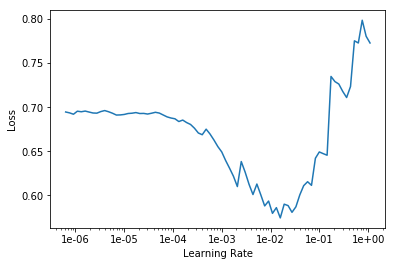

In [12]:
learn = Learner(db, model, metrics = [accuracy])
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(7,3*1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.649945,0.577973,0.712500,01:24
1,0.500811,0.426944,0.775000,01:24
2,0.458330,0.453005,0.775000,01:24
3,0.393657,0.464990,0.787500,01:24
4,0.292346,0.425390,0.812500,01:24
5,0.196943,0.432047,0.825000,01:24
6,0.137170,0.439046,0.825000,01:24


In [20]:
# For inference on the test set
learn.save('5_ep_1e-3')